In [6]:
import pandas as pd
import numpy as np
from scipy import spatial
import geopandas as gpd
from shapely.geometry import Point, LineString, Polygon
import fiona
import statistics
import contextily as cx

In [7]:
mypath = '../../data/3 vehicles/'

In [8]:
from os import listdir
from os.path import isfile, join
onlyfiles = [f for f in listdir(mypath) if isfile(join(mypath, f))]

In [9]:
def filterSubstr(lists, substr):
    return [x for x in lists if substr in x]

searchString = '2022_09_13'
onlyfiles_13_09 = filterSubstr(onlyfiles, searchString)
onlyfiles_13_09

searchString = '_09_0'
onlyfiles = filterSubstr(onlyfiles_13_09, searchString)
onlyfiles

['2022_09_13_LA2 Logi Jeep_09_06_09_22_41ab7e72-261b-4d62-9c98-e08ba9481c14.csv',
 '2022_09_13_PS Skylark Test_09_09_09_23_23351042-777c-4a84-9d81-b74d77210823.csv',
 '2022_09_13_RW2 Logi Jeep_09_06_09_22_d8471341-6779-4d27-8ca6-4ef30c5f93a0.csv']

In [10]:
allfiles = []
for i in range(len(onlyfiles)):
    df = pd.read_csv(mypath + str(onlyfiles[i]), sep=';', decimal=',')
    df['Time[ms]'] = pd.to_datetime(df['Time[ms]'], unit='ms')
    df['driver'] = str(onlyfiles[i])[11:13]
    coord_ = [Point(x, y) for x, y in zip(df.Longitude, df.Latitude)]
    alldata_ = gpd.GeoDataFrame(df, geometry=coord_, crs ="EPSG:4326")
    allfiles.append(df)
alldata = pd.concat(allfiles, axis=0).reset_index(drop=True)

In [11]:
alldata['data'] = alldata['Time[ms]'].dt.date

In [12]:
alldata["data"] = pd.to_datetime(alldata["data"])

In [13]:
alldata_RW = alldata[alldata.driver == 'RW']
alldata_PS = alldata[alldata.driver == 'PS']
alldata_LA = alldata[alldata.driver == 'LA']

In [14]:
allfiles = []
for i in range(len(onlyfiles)):
    df = pd.read_csv(mypath + str(onlyfiles[i]), sep=';', decimal=',')
    df['Time[ms]'] = pd.to_datetime(df['Time[ms]'], unit='ms')
    df['driver'] = str(onlyfiles[i])[11:13]
    coord_ = [Point(x, y) for x, y in zip(df.Longitude, df.Latitude)]
    alldata_ = gpd.GeoDataFrame(df, geometry=coord_, crs ="EPSG:4326")
    allfiles.append(df)

In [15]:
alldata = pd.concat(allfiles, axis=0).reset_index(drop=True)

In [16]:
alldata.driver.unique()

array(['LA', 'PS', 'RW'], dtype=object)

In [17]:
alldata_SORTED = alldata.sort_values(by = 'Time[ms]').reset_index(drop=True)

In [18]:
alldata_SORTED_cut = alldata_SORTED.dropna().reset_index(drop=True)

In [19]:
alldata_SORTED_cut['Time'] = pd.to_datetime(alldata_SORTED_cut['Time[ms]'].dt.strftime('%H:%M:%S'))

In [20]:
rw = alldata_SORTED_cut[alldata_SORTED_cut.driver == 'RW'].reset_index(drop=True).drop_duplicates()
la = alldata_SORTED_cut[alldata_SORTED_cut.driver == 'LA'].reset_index(drop=True).drop_duplicates()
ps = alldata_SORTED_cut[alldata_SORTED_cut.driver == 'PS'].reset_index(drop=True).drop_duplicates()

In [21]:
from haversine import haversine, Unit
import haversine as hs

In [22]:
platoon_alldist = []
platoon_all_CO2 = []

platoon_all_lat_dist = []
platoon_all_lon_dist = []

platoon_all_lat_CO2 = []
platoon_all_lon_CO2 = []

#ps --> rw
#jc --> la
#dw --> ps


for i in range(len(rw)):
    platoon_lat_dist = []
    platoon_lon_dist = []
    platoon_lat_CO2 = []
    platoon_lon_CO2 = []
    platoon_dist = []
    CO2_max = []
    dist_mat = []
    
    rw_ = rw.iloc[i]
    
    df_array1 = (rw_.Latitude, rw_.Longitude)

    la_ = la[la['Time'] > rw_['Time']].reset_index(drop=True)
    df_array2 = list(zip(la_.Latitude, la_.Longitude))[0:60]
        
    for j in range(len(df_array2)):
        dist_mat.append(hs.haversine(df_array1,df_array2[j],unit=Unit.METERS))

    la_mindist = min(dist_mat)
    la_mindist_index = dist_mat.index(la_mindist)

    platoon_dist.append(la_mindist)

    platoon_lat_dist.append(la_.iloc[la_mindist_index]["Latitude"])
    platoon_lon_dist.append(la_.iloc[la_mindist_index]["Longitude"])

    CO2 = []
    CO2.append(la_.iloc[0]['CO2[kg]'])
    try:
        CO2.extend(list(la_.iloc[1:21]['CO2[kg]']))
    except:
        pass
    
    la_maxCO2 = max(CO2)
    la_maxCO2_index = CO2.index(la_maxCO2)
    CO2_max.append(la_.reset_index(drop=True).iloc[la_maxCO2_index]['CO2[kg]'])
    platoon_lat_CO2.append(la_.reset_index(drop=True).iloc[la_maxCO2_index]["Latitude"])
    platoon_lon_CO2.append(la_.reset_index(drop=True).iloc[la_maxCO2_index]["Longitude"])    


    ps_ = ps[ps['Time'] > la_['Time'][la_mindist_index]].reset_index(drop=True)
    df_array3 = list(zip(ps_.Latitude, ps_.Longitude))[0:60]        
    
    dist_mat = []

    for j in range(len(df_array3)):
        dist_mat.append(hs.haversine(df_array2[la_mindist_index],df_array3[j],unit=Unit.METERS))

    ps_mindist = min(dist_mat)
    ps_mindist_index = dist_mat.index(ps_mindist)

    platoon_dist.append(ps_mindist)
    platoon_lat_dist.append(ps_.reset_index(drop=True).iloc[ps_mindist_index]["Latitude"])
    platoon_lon_dist.append(ps_.reset_index(drop=True).iloc[ps_mindist_index]["Longitude"])    

    CO2 = []

    CO2.append(ps_.iloc[0]['CO2[kg]'])
    try:
        CO2.extend(list(ps_.iloc[1:21]['CO2[kg]']))
    except:
        pass
    ps_maxCO2 = max(CO2)
    ps_maxCO2_index = CO2.index(ps_maxCO2)
    CO2_max.append(ps_.reset_index(drop=True).iloc[ps_maxCO2_index]['CO2[kg]'])
    platoon_lat_CO2.append(ps_.reset_index(drop=True).iloc[ps_maxCO2_index]["Latitude"])
    platoon_lon_CO2.append(ps_.reset_index(drop=True).iloc[ps_maxCO2_index]["Longitude"])  

      
    platoon_all_lat_dist.append(platoon_lat_dist)
    platoon_all_lon_dist.append(platoon_lon_dist)
    platoon_all_lat_CO2.append(platoon_lat_CO2)
    platoon_all_lon_CO2.append(platoon_lon_CO2)
    platoon_alldist.append(platoon_dist)
    platoon_all_CO2.append(CO2_max)

<Axes: >

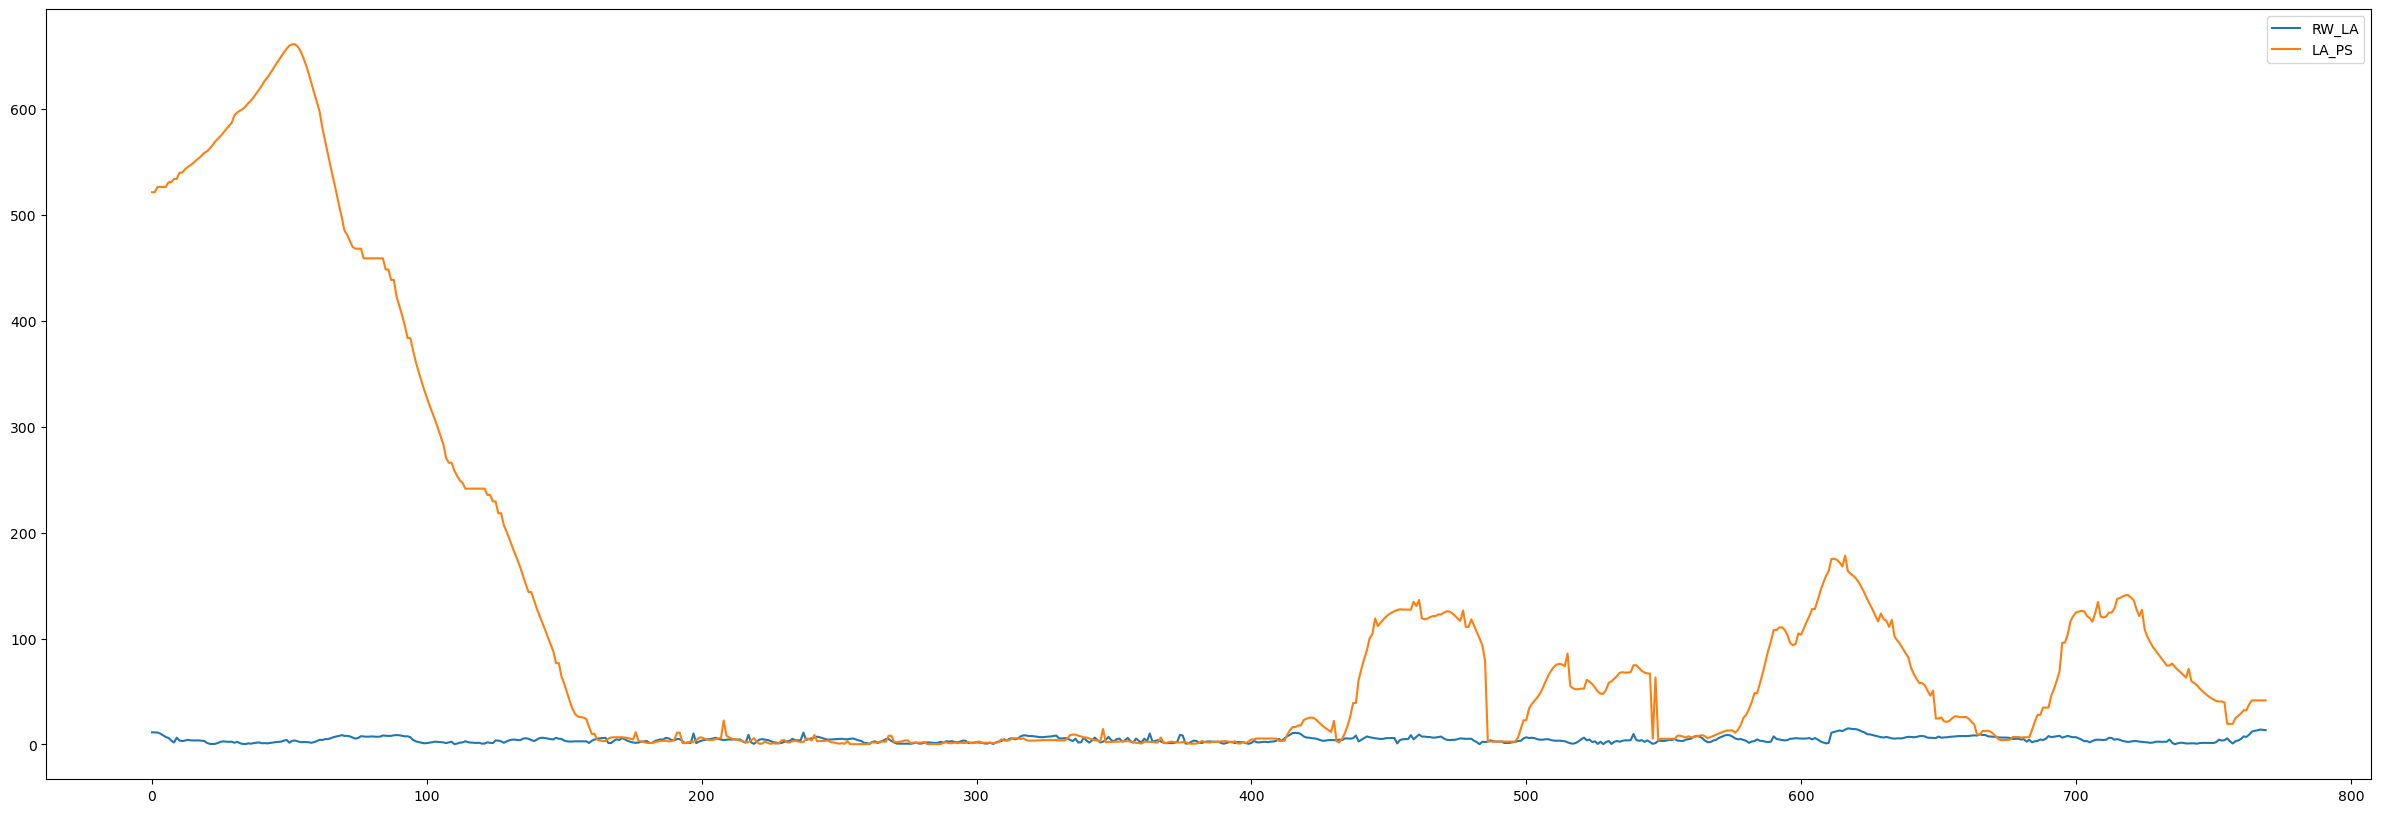

In [23]:
pd.DataFrame(platoon_alldist, columns = ['RW_LA', 'LA_PS']).plot(figsize=(30,10))

In [24]:
dist_v = pd.DataFrame(platoon_alldist, columns = ['RW_LA', 'LA_PS'])
pd.DataFrame(platoon_alldist, columns = ['RW_LA', 'LA_PS']).to_csv('distance_platoon.csv', index=False)
dist_v

,RW_LA,LA_PS
0,11.461730,521.173299
1,11.355808,521.173299
2,11.304709,526.177781
3,10.252057,526.177781
4,8.698830,526.177781
...,...,...
765,12.928819,41.600722
766,13.384117,41.600722
767,14.105176,41.600722
768,13.859103,41.600722


In [25]:
dist_coord = pd.concat([pd.DataFrame(platoon_all_lat_dist, columns=['v1_lat', 'v2_lat'])['v1_lat'], pd.DataFrame(platoon_all_lon_dist, columns=['v1_lon', 'v2_lon'])['v1_lon'],pd.DataFrame(platoon_all_lat_dist, columns=['v1_lat', 'v2_lat'])['v2_lat'], pd.DataFrame(platoon_all_lon_dist, columns=['v1_lon', 'v2_lon'])['v2_lon']], axis=1)
dist_coord

,v1_lat,v1_lon,v2_lat,v2_lon
0,53.560258,9.980813,53.556203,9.976856
1,53.560258,9.980813,53.556203,9.976856
2,53.560332,9.980748,53.556203,9.976856
3,53.560332,9.980748,53.556203,9.976856
4,53.560332,9.980748,53.556203,9.976856
...,...,...,...,...
765,53.560223,9.981080,53.560022,9.981611
766,53.560223,9.981080,53.560022,9.981611
767,53.560223,9.981080,53.560022,9.981611
768,53.560223,9.981080,53.560022,9.981611


In [26]:
def f(row):
    return hs.haversine((row['v1_lat'],row['v1_lon']),(row['v2_lat'],row['v2_lon']),unit=Unit.METERS)
f(dist_coord.iloc[769,:])

41.60072221278283

In [27]:
pd.concat([pd.DataFrame(platoon_all_lat_dist, columns=['v1_lat', 'v2_lat'])['v1_lat'], pd.DataFrame(platoon_all_lon_dist, columns=['v1_lon', 'v2_lon'])['v1_lon'],pd.DataFrame(platoon_all_lat_dist, columns=['v1_lat', 'v2_lat'])['v2_lat'], pd.DataFrame(platoon_all_lon_dist, columns=['v1_lon', 'v2_lon'])['v2_lon']], axis=1).to_csv('platoon_distances_coord.csv', index=False)

In [28]:
infr = pd.read_csv('../../data/infrast_data_update_.csv', sep=';')
infr.what.unique()

array(['Turn_left', '4-ways intersection', 'Traffic_light', 'Curve',
       'Road_immission', 'Turn_right'], dtype=object)

In [29]:
allveic = []
for k in range(0, len(dist_coord.columns)-1, 2):
    veic = []
    for i in range(len(dist_coord)):
        infra = []
        for j in range(len(infr)):
            inf = (infr.iloc[j].lat,infr.iloc[j].lon)
            distcoor = (dist_coord.iloc[i][str(dist_coord.columns[k])], dist_coord.iloc[i][str(dist_coord.columns[k+1])])
            infra.append(hs.haversine(inf,distcoor,unit=Unit.METERS))
        veic.append(infra)
    allveic.append(veic)

In [30]:
allveic[0]

[[1759.1229543711913,
  1359.5473198117895,
  1740.6249846072978,
  1358.3081856717736,
  1358.3081856717736,
  1356.1561985589005,
  1340.086730056207,
  1746.1231884491115,
  1311.0763974209053,
  1276.2948325521986,
  1276.2948325521986,
  1268.5197103860248,
  1261.3094771873095,
  1240.033869241646,
  1268.5344256290798,
  1276.0888333633889,
  1557.3547622921835,
  1738.821996339008,
  896.1798226229893,
  1262.5217382873027,
  1262.5217382873027,
  1747.7706335933542,
  1236.6694847017584,
  1210.4590693051252,
  1021.7366700397513,
  1780.794149041524,
  543.722150835624,
  558.1788924766261,
  357.21853872189865,
  360.8835744125336,
  356.5397975529758,
  390.5292326478571,
  390.3410965212337,
  934.1967649931845,
  391.6366500851795,
  398.0717620952461,
  398.39636268261575,
  389.46484421826045,
  388.08892667871424,
  884.8858937992403,
  1827.972642742662,
  400.6852984606538,
  400.6852984606538,
  475.06492564095385,
  520.1696443476931,
  508.2082342962303,
  508.208

In [31]:
v1 = pd.DataFrame(allveic[0])
v2 = pd.DataFrame(allveic[1])

In [32]:
v1

,0,1,2,3,4,5,6,7,8,9,...,82,83,84,85,86,87,88,89,90,91
0,1759.122954,1359.547320,1740.624985,1358.308186,1358.308186,1356.156199,1340.086730,1746.123188,1311.076397,1276.294833,...,863.359483,863.615788,863.615788,886.485419,890.188579,903.213854,903.480817,903.480817,879.116983,879.116983
1,1759.122954,1359.547320,1740.624985,1358.308186,1358.308186,1356.156199,1340.086730,1746.123188,1311.076397,1276.294833,...,863.359483,863.615788,863.615788,886.485419,890.188579,903.213854,903.480817,903.480817,879.116983,879.116983
2,1764.709815,1364.032431,1746.190450,1362.791607,1362.791607,1360.650002,1344.517178,1751.716344,1315.452729,1280.676809,...,870.324663,870.506237,870.506237,893.240808,896.944403,909.782355,910.051504,910.051504,884.889860,884.889860
3,1764.709815,1364.032431,1746.190450,1362.791607,1362.791607,1360.650002,1344.517178,1751.716344,1315.452729,1280.676809,...,870.324663,870.506237,870.506237,893.240808,896.944403,909.782355,910.051504,910.051504,884.889860,884.889860
4,1764.709815,1364.032431,1746.190450,1362.791607,1362.791607,1360.650002,1344.517178,1751.716344,1315.452729,1280.676809,...,870.324663,870.506237,870.506237,893.240808,896.944403,909.782355,910.051504,910.051504,884.889860,884.889860
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
765,1763.293542,1366.189482,1744.847552,1364.953975,1364.953975,1362.780790,1346.843588,1750.279771,1317.947310,1283.158533,...,845.505351,845.730290,845.730290,868.551043,872.254367,885.226971,885.494454,885.494454,861.074300,861.074300
766,1763.293542,1366.189482,1744.847552,1364.953975,1364.953975,1362.780790,1346.843588,1750.279771,1317.947310,1283.158533,...,845.505351,845.730290,845.730290,868.551043,872.254367,885.226971,885.494454,885.494454,861.074300,861.074300
767,1763.293542,1366.189482,1744.847552,1364.953975,1364.953975,1362.780790,1346.843588,1750.279771,1317.947310,1283.158533,...,845.505351,845.730290,845.730290,868.551043,872.254367,885.226971,885.494454,885.494454,861.074300,861.074300
768,1763.293542,1366.189482,1744.847552,1364.953975,1364.953975,1362.780790,1346.843588,1750.279771,1317.947310,1283.158533,...,845.505351,845.730290,845.730290,868.551043,872.254367,885.226971,885.494454,885.494454,861.074300,861.074300


In [33]:
allfeat = []
for i in range(len(v1)): 
    allfeat.append(list(v1[v1<500].iloc[i].dropna()))
new_v1 = pd.DataFrame(allfeat).iloc[:,0:7].fillna(0)
new_v1

,0,1,2,3,4,5,6
0,357.218539,360.883574,356.539798,390.529233,390.341097,391.636650,398.071762
1,357.218539,360.883574,356.539798,390.529233,390.341097,391.636650,398.071762
2,352.618972,354.729755,350.506479,390.981151,390.821448,392.558419,389.659626
3,352.618972,354.729755,350.506479,390.981151,390.821448,392.558419,389.659626
4,352.618972,354.729755,350.506479,390.981151,390.821448,392.558419,389.659626
...,...,...,...,...,...,...,...
765,375.025871,378.924333,374.588544,404.095123,403.871141,404.589723,414.468114
766,375.025871,378.924333,374.588544,404.095123,403.871141,404.589723,414.468114
767,375.025871,378.924333,374.588544,404.095123,403.871141,404.589723,414.468114
768,375.025871,378.924333,374.588544,404.095123,403.871141,404.589723,414.468114


In [34]:
allfeat = []
for i in range(len(v2)): 
    allfeat.append(list(v2[v2<500].iloc[i].dropna()))
new_v2 = pd.DataFrame(allfeat).iloc[:,0:7].fillna(0)

In [35]:
v1.columns = infr.what
v2.columns = infr.what

In [36]:
vlist = []
vlist.append(v1)
vlist.append(v2)

In [37]:
import statsmodels.api as sm

In [38]:
all_X = []
all_y = []

for k in range(len(vlist)):
    feats = []
    v = vlist[k]
    infrast = v.idxmin(axis=1)
    for i in range(len(v)):
        if (v.iloc[i][str(infrast[i])] < 80).any():
            feats.append([infrast[i]])
        else:
            feats.append([])
    new_v = pd.get_dummies(pd.DataFrame(feats), prefix='Feat')

    X = new_v.copy()
    y = dist_v[str(dist_v.columns[k])]
    X['old_dist'] = dist_v[str(dist_v.columns[k])].shift(10).fillna(0)
    all_X.append(X)
    all_y.append(y)

all_X_ = pd.concat(all_X).reset_index(drop=True).fillna(0)
all_y_ = pd.concat(all_y).reset_index(drop=True).fillna(0)
model = sm.OLS(y, X).fit()
predictions = model.predict(X)
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  LA_PS   R-squared (uncentered):                   0.899
Model:                            OLS   Adj. R-squared (uncentered):              0.898
Method:                 Least Squares   F-statistic:                              971.0
Date:                Tue, 08 Aug 2023   Prob (F-statistic):                        0.00
Time:                        19:59:39   Log-Likelihood:                         -4332.6
No. Observations:                 770   AIC:                                      8679.
Df Residuals:                     763   BIC:                                      8712.
Df Model:                           7                                                  
Covariance Type:            nonrobust                                                  
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Feat_4-ways intersection   -10.8484     13.273     -0.817      0.414     -36.905      15.208
Feat_Curve                   3.9772     10.698      0.372      0.710     -17.023      24.978
Feat_Road_immission         -1.3560     12.332     -0.110      0.912     -25.564      22.852
Feat_Traffic_light          18.6482      3.559      5.239      0.000      11.661      25.636
Feat_Turn_left             -29.0430      9.681     -3.000      0.003     -48.047     -10.039
Feat_Turn_right            -11.4375     11.293     -1.013      0.311     -33.607      10.732
old_dist                     0.9789      0.020     48.172      0.000       0.939       1.019
==============================================================================
Omnibus:                      875.211   Durbin-Watson:                   0.098
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            56212.607
Skew:                           5.614   Prob(JB):                         0.00
Kurtosis:                      43.324   Cond. No.                     1.16e+03
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[3] The condition number is large, 1.16e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [39]:
feats

[['Traffic_light'],
 ['Traffic_light'],
 ['Traffic_light'],
 ['Traffic_light'],
 ['Traffic_light'],
 ['Traffic_light'],
 ['Traffic_light'],
 ['Traffic_light'],
 ['Traffic_light'],
 ['Traffic_light'],
 ['Traffic_light'],
 ['Traffic_light'],
 ['Traffic_light'],
 ['Traffic_light'],
 ['Traffic_light'],
 ['Traffic_light'],
 ['Traffic_light'],
 ['Traffic_light'],
 ['Traffic_light'],
 ['Traffic_light'],
 ['Traffic_light'],
 ['Traffic_light'],
 ['Traffic_light'],
 ['Traffic_light'],
 ['Traffic_light'],
 ['Traffic_light'],
 ['Turn_left'],
 ['Turn_left'],
 ['Turn_left'],
 ['Turn_left'],
 ['Turn_left'],
 ['Turn_left'],
 ['Turn_left'],
 ['Turn_left'],
 ['Turn_left'],
 ['Turn_left'],
 ['Turn_left'],
 ['Turn_left'],
 ['Turn_left'],
 ['Turn_left'],
 ['Turn_left'],
 ['Turn_left'],
 ['Turn_left'],
 ['Turn_left'],
 ['Turn_left'],
 ['Turn_left'],
 ['Turn_left'],
 ['Turn_left'],
 ['Turn_left'],
 ['Turn_left'],
 ['Turn_left'],
 ['Turn_left'],
 ['Turn_left'],
 ['Turn_left'],
 ['Turn_left'],
 ['Turn_left'],


In [40]:
y


0      521.173299
1      521.173299
2      526.177781
3      526.177781
4      526.177781
          ...    
765     41.600722
766     41.600722
767     41.600722
768     41.600722
769     41.600722
Name: LA_PS, Length: 770, dtype: float64

In [41]:
results_summary = model.summary()
df = pd.DataFrame.from_records(results_summary.tables[1].data)
header = df.iloc[0]
df = df[1:] # take the data less the header row
df.columns = header
df.to_csv('../../risultati/Dist/platoon_II_13_09_09_09_09.csv')

In [42]:
platoon_all_CO2_ = pd.DataFrame(platoon_all_CO2, columns = ['RW_LA', 'LA_PS'])
pd.DataFrame(platoon_all_CO2, columns = ['RW_LA', 'LA_PS']).to_csv('CO2_platoon.csv', index=False)

In [43]:
all_X = []
all_y = []

for k in range(len(vlist)):
    feats = []
    v = vlist[k]
    infrast = v.idxmin(axis=1)
    for i in range(len(v)):
        if (v.iloc[i][str(infrast[i])] < 100).any():
            feats.append([infrast[i]])
        else:
            feats.append([])
    new_v = pd.get_dummies(pd.DataFrame(feats), prefix='Feat')

    X = new_v.copy()
    y = platoon_all_CO2_[str(platoon_all_CO2_.columns[k])]
    X['old_dist'] = dist_v[str(dist_v.columns[k])].shift(10).fillna(0)
    all_X.append(X)
    all_y.append(y)

all_X_ = pd.concat(all_X).reset_index(drop=True).fillna(0)
all_y_ = pd.concat(all_y).reset_index(drop=True).fillna(0)
model = sm.OLS(y, X).fit()
predictions = model.predict(X)
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  LA_PS   R-squared (uncentered):                   0.627
Model:                            OLS   Adj. R-squared (uncentered):              0.623
Method:                 Least Squares   F-statistic:                              183.0
Date:                Tue, 08 Aug 2023   Prob (F-statistic):                   1.43e-158
Time:                        20:00:46   Log-Likelihood:                          3330.9
No. Observations:                 770   AIC:                                     -6648.
Df Residuals:                     763   BIC:                                     -6615.
Df Model:                           7                                                  
Covariance Type:            nonrobust                                                  
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Feat_4-ways intersection     0.0016      0.001      2.769      0.006       0.000       0.003
Feat_Curve                   0.0040      0.000      8.421      0.000       0.003       0.005
Feat_Road_immission          0.0063      0.001     11.127      0.000       0.005       0.007
Feat_Traffic_light           0.0042      0.000     25.618      0.000       0.004       0.005
Feat_Turn_left               0.0035      0.000      7.624      0.000       0.003       0.004
Feat_Turn_right              0.0054      0.001     10.125      0.000       0.004       0.006
old_dist                  8.104e-07   9.68e-07      0.838      0.402   -1.09e-06    2.71e-06
==============================================================================
Omnibus:                       17.184   Durbin-Watson:                   0.071
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               14.594
Skew:                           0.267   Prob(JB):                     0.000677
Kurtosis:                       2.587   Cond. No.                     1.08e+03
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[3] The condition number is large, 1.08e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [44]:
results_summary = model.summary()
df = pd.DataFrame.from_records(results_summary.tables[1].data)
header = df.iloc[0]
df = df[1:] # take the data less the header row
df.columns = header
df.to_csv('../../risultati/CO2/platoon_II_13_09_09_09_09_CO2.csv')